# Оценка работы библиотеки по извлечению текста новости

- <font color="grey">Выполнил:</font> Ковальчук Василий ([cv.kov.app](cv.kov.app), [+7-905-272-22-51](tel:+79052722251), [v@kov.app](mailto:v@kov.app))
- <font color="grey">Дата:</font> 2025-05-23

## Введение

### Цели

- Выполнить оценку работы библиотеки по извлечению текста новости.
- Необходимо определить полноту извлекаемого текста и оценить значимость тех частей текста, которые выделить не удалось.
- Проанализировать и предложить изменения в алгоритм работы библиотеки.

### Описание данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_excel(r'data/Test_check.xlsx')
data_stat = pd.concat(
    [
        data.describe(),
        data.map(len).agg(['min', 'median', 'max'])
    ]
)
display(data_stat)
display(data.head(10))

URL  \
count                                                  50   
unique                                                 50   
top     https://expert.ru/ekonomika/vygodna-li-rossii-...   
freq                                                    1   
min                                                  36.0   
median                                               53.5   
max                                                 182.0   

                                                 lib_text  
count                                                  50  
unique                                                 48  
top     Основатель компании SpaceX Илон Маск заявил, ч...  
freq                                                    2  
min                                                1323.0  
median                                             8604.0  
max                                               32025.0

URL  \
0  https://expert.ru/ekonomika/vygodna-li-rossii-...   
1  https://ria.ru/20250311/klyuchevaya_stavka-196...   
2  https://expert.ru/mnenie/denis-manturov-gosuda...   
3    https://ria.ru/20250304/kredity-2003042476.html   
4           https://lenta.ru/brief/2025/03/11/green/   
5        https://lenta.ru/articles/2025/03/09/aslan/   
6  https://expert.ru/finance/investorov-svyazyvay...   
7        https://ria.ru/20250123/svo-1985822676.html   
8  https://expert.ru/mnenie/vse-teper-zavisit-tol...   
9      https://ria.ru/docs/about/privacy_policy.html   

                                            lib_text  
0  Серьезнее других от введения западных санкций ...  
1  МОСКВА, 14 фев — РИА Новости Ключевая процентн...  
2  Со следующего года начнется реализация 12 мега...  
3  Самозапрет на кредиты - это новая возможность ...  
4  Заходя в магазин, вы часто замечали зеленые уп...  
5  20 лет назад, 8 марта 2005 года, в чеченском с...  
6  Говоря сухим языком определений, цифровые фина...  
7  Поддержка военнослужащих и их семей с самого н...  
8  — За последние два с половиной года из-за введ...  
9  Федеральное государственное унитарное предприя...

Нам доступна выборка из 50 записей, которые состоят из:
- URL-адреса новости
- извлечённый оцениваемой библиотекой текст новости

Текст содержит от 1323 до 32025 символов, медианная длина - 8604 символов. Обращаем внимание, что в тексте есть дубликаты. В данных нет пропусков.

### Содержание

- анализ данных на особенности и корректность;
- получение эталонных текстов;
- определение baseline для сравнения работы алгоритма;
- определить и вычислить метрики полноты извлечённых текстов;
- определить и вычислить метрики важности потерянной информации в извлечённых текстах.

## Исследование

### Анализ данных на особенности и корректность

Обращаем внимание, что часть текстов дублируется (2), при этом ссылки все уникальны

In [2]:
data[data['lib_text'].duplicated(keep=False)]

URL  \
9       https://ria.ru/docs/about/privacy_policy.html   
10  https://ria.ru/docs/about/privacy_policy.html#...   
11  https://lenta.ru/extlink/2025/03/10/na-ukraine...   
12  https://lenta.ru/news/2025/03/10/na-ukraine-is...   

                                             lib_text  
9   Федеральное государственное унитарное предприя...  
10  Федеральное государственное унитарное предприя...  
11  Основатель компании SpaceX Илон Маск заявил, ч...  
12  Основатель компании SpaceX Илон Маск заявил, ч...

Отмечам две особенности:
- есть ссылки, которые не содержат новости (ссылка ria.ru на их политику обработки персданных). Такие ссылки выходят за пределы исследуемой области, поэтому их нужно будет удалить;
- ссылки могут быть якорными (ссылаться на конкретный участок текста в статье через символ решётки `#`);
- ссылка может переадресовывать на другие страницы, в том числе на страницы с уже извлечённым текстом. Из таких записей нужно оставить одну основную.

In [3]:
data['to_drop'] = data['URL'].str.contains("https://ria.ru/docs/about/privacy_policy.html")

Для каждой ссылки в списке определим финальную ссылку (с учётом перенаправлений). Заодно мы проверим не битые ли это ссылки.

In [4]:
import requests

temp = dict()

for _, url in data['URL'].items():
    response = requests.head(url, allow_redirects=True)

    temp[url] = {
        'redirect_final_url': response.url,
        'status_code': response.status_code
    }

In [5]:
# Объединим с оригинальным датасетом
data_with_urls = pd.DataFrame(temp).T.join(data.set_index('URL'))
backup = data_with_urls.copy()

assert (data_with_urls.status_code == 200).all() == True, 'Один или несколько запросов завершился с ошибкой. Сервер не доступен?'

Ссылки не биты, все вернули 200 ответ сервера. Выведем записи, у который оригинальный и финальный URL не совпадают.

In [6]:
is_url_differentiate = data_with_urls.index != data_with_urls['redirect_final_url']
data_with_urls[is_url_differentiate]

redirect_final_url  \
https://ria.ru/20250311/klyuchevaya_stavka-1962...  https://ria.ru/20250520/klyuchevaya_stavka-196...   
https://ria.ru/20250304/kredity-2003042476.html       https://ria.ru/20250430/kredity-2003042476.html   
https://lenta.ru/extlink/2025/03/10/na-ukraine-...  https://lenta.ru/news/2025/03/10/na-ukraine-is...   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...  https://lenta.ru/articles/2025/03/08/rynochek-...   
https://lenta.ru/extlink/2025/03/10/putin-konta...   https://lenta.ru/articles/2025/03/09/baba-vanga/   
https://ria.ru/20241220/shtrafy-1990507458.html       https://ria.ru/20250401/shtrafy-1990507458.html   
https://ria.ru/20250311/matkapital-1733022511.html  https://ria.ru/20250411/matkapital-1733022511....   

                                                   status_code  \
https://ria.ru/20250311/klyuchevaya_stavka-1962...         200   
https://ria.ru/20250304/kredity-2003042476.html            200   
https://lenta.ru/extlink/2025/03/10/na-ukraine-...         200   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...         200   
https://lenta.ru/extlink/2025/03/10/putin-konta...         200   
https://ria.ru/20241220/shtrafy-1990507458.html            200   
https://ria.ru/20250311/matkapital-1733022511.html         200   

                                                                                             lib_text  \
https://ria.ru/20250311/klyuchevaya_stavka-1962...  МОСКВА, 14 фев — РИА Новости Ключевая процентн...   
https://ria.ru/20250304/kredity-2003042476.html     Самозапрет на кредиты - это новая возможность ...   
https://lenta.ru/extlink/2025/03/10/na-ukraine-...  Основатель компании SpaceX Илон Маск заявил, ч...   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...  2025 год может стать для России годом «увольне...   
https://lenta.ru/extlink/2025/03/10/putin-konta...  Личность болгарской ясновидящей Ванги окутана ...   
https://ria.ru/20241220/shtrafy-1990507458.html     МОСКВА, 20 дек — РИА Новости. Штрафы ГИБДД за ...   
https://ria.ru/20250311/matkapital-1733022511.html  МОСКВА, 12 мар - РИА Новости. Материнский капи...   

                                                    to_drop  
https://ria.ru/20250311/klyuchevaya_stavka-1962...    False  
https://ria.ru/20250304/kredity-2003042476.html       False  
https://lenta.ru/extlink/2025/03/10/na-ukraine-...    False  
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...    False  
https://lenta.ru/extlink/2025/03/10/putin-konta...    False  
https://ria.ru/20241220/shtrafy-1990507458.html       False  
https://ria.ru/20250311/matkapital-1733022511.html    False

Видим, что у РИА есть динамические страницы с анализом текущей (на момент открытия ссылки) ситуации предмета статьи, как, например, ключевой ставки, штрафов, кредитов и др. Это не позволит нам извлечь эталонный текст на момент извлечения текста, а значит невозможно будет оценить работу библиотеки. Данные строки придётся отбросить.

В ссылка на Ленту у нас несколько URL, содержащих в пути "extlink", которые перенаправляют запросы на другой URL на их сайте. Из-за это возможны дубликаты в базе хранения извлечённого текста, поэтому отбросим дубликаты по признаку "финальный url".

In [7]:
is_ria = data_with_urls['redirect_final_url'].str.contains("ria.ru")
# помечаем кандидаты на удаление по признаку несовпадения финального url с оригинальным url и принадлежности к ria.ru
data_with_urls['to_drop'] = data_with_urls['to_drop'] | (is_url_differentiate & is_ria)
# помечаем кандидаты на удаление по признаку несовпадения финального url с оригинальным url и принадлежности к ria.ru
data_with_urls['to_drop'] = data_with_urls['to_drop'] | data_with_urls['redirect_final_url'].duplicated('last')
(~data_with_urls['to_drop']).sum()

np.int64(43)

В итоге у нас осталось 43 записи для анализа, выгрузим в таблицу для будущего заполнения.

In [8]:
data_with_urls[~data_with_urls['to_drop']].to_excel("data/cleaned_urls.xlsx")

### Получение эталонных записей

Эталонные записи мы получили в ручном режиме.
- удалены все пустые строки;
- в списках перед всеми пунктами добавлена строка "- ";
- в текст добавлены заголовки, подзаголовки и подводки (в оригинальном датасете они были вырезаны из текста);
- цитаты, заголовки, таблицы никак не выделены;
- не включались метаданные (даты, время, авторы статьи, теги);
- проигнорированы фотографии и подписи к ним;
- не включены рекламные блоки и блоки типа "Связанные материалы";
- не включены шапка, боковые панели, содержание, комментарии пользователей;
- сноски сохранены.

In [9]:
human_data = pd.read_excel("data/cleaned_urls_human_texts.xlsx", index_col=0)
human_data_stat = pd.concat(
    [
        human_data[['lib_text', 'human_text']].describe(),
        human_data[['lib_text', 'human_text']].map(len).agg(['min', 'median', 'max'])
    ]
)
display(human_data_stat)
display(human_data.head(10))

lib_text  \
count                                                  43   
unique                                                 43   
top     Серьезнее других от введения западных санкций ...   
freq                                                    1   
min                                                1323.0   
median                                             6478.0   
max                                               32025.0   

                                               human_text  
count                                                  43  
unique                                                 43  
top     Выгодна ли России отмена санкций США\nОслаблен...  
freq                                                    1  
min                                                1606.0  
median                                             7153.0  
max                                               32832.0

redirect_final_url  \
https://expert.ru/ekonomika/vygodna-li-rossii-o...  https://expert.ru/ekonomika/vygodna-li-rossii-...   
https://expert.ru/mnenie/denis-manturov-gosudar...  https://expert.ru/mnenie/denis-manturov-gosuda...   
https://lenta.ru/brief/2025/03/11/green/                     https://lenta.ru/brief/2025/03/11/green/   
https://lenta.ru/articles/2025/03/09/aslan/               https://lenta.ru/articles/2025/03/09/aslan/   
https://expert.ru/finance/investorov-svyazyvayu...  https://expert.ru/finance/investorov-svyazyvay...   
https://ria.ru/20250123/svo-1985822676.html               https://ria.ru/20250123/svo-1985822676.html   
https://expert.ru/mnenie/vse-teper-zavisit-tolk...  https://expert.ru/mnenie/vse-teper-zavisit-tol...   
https://lenta.ru/news/2025/03/10/na-ukraine-isp...  https://lenta.ru/news/2025/03/10/na-ukraine-is...   
https://expert.ru/news/rynok-onlayn-torgovli-v-...  https://expert.ru/news/rynok-onlayn-torgovli-v...   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...  https://lenta.ru/articles/2025/03/08/rynochek-...   

                                                    status_code  \
https://expert.ru/ekonomika/vygodna-li-rossii-o...          200   
https://expert.ru/mnenie/denis-manturov-gosudar...          200   
https://lenta.ru/brief/2025/03/11/green/                    200   
https://lenta.ru/articles/2025/03/09/aslan/                 200   
https://expert.ru/finance/investorov-svyazyvayu...          200   
https://ria.ru/20250123/svo-1985822676.html                 200   
https://expert.ru/mnenie/vse-teper-zavisit-tolk...          200   
https://lenta.ru/news/2025/03/10/na-ukraine-isp...          200   
https://expert.ru/news/rynok-onlayn-torgovli-v-...          200   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...          200   

                                                                                             lib_text  \
https://expert.ru/ekonomika/vygodna-li-rossii-o...  Серьезнее других от введения западных санкций ...   
https://expert.ru/mnenie/denis-manturov-gosudar...  Со следующего года начнется реализация 12 мега...   
https://lenta.ru/brief/2025/03/11/green/            Заходя в магазин, вы часто замечали зеленые уп...   
https://lenta.ru/articles/2025/03/09/aslan/         20 лет назад, 8 марта 2005 года, в чеченском с...   
https://expert.ru/finance/investorov-svyazyvayu...  Говоря сухим языком определений, цифровые фина...   
https://ria.ru/20250123/svo-1985822676.html         Поддержка военнослужащих и их семей с самого н...   
https://expert.ru/mnenie/vse-teper-zavisit-tolk...  — За последние два с половиной года из-за введ...   
https://lenta.ru/news/2025/03/10/na-ukraine-isp...  Основатель компании SpaceX Илон Маск заявил, ч...   
https://expert.ru/news/rynok-onlayn-torgovli-v-...  По данным INFOLine, на e-com в 2024 году пришл...   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...  2025 год может стать для России годом «увольне...   

                                                    to_drop  \
https://expert.ru/ekonomika/vygodna-li-rossii-o...    False   
https://expert.ru/mnenie/denis-manturov-gosudar...    False   
https://lenta.ru/brief/2025/03/11/green/              False   
https://lenta.ru/articles/2025/03/09/aslan/           False   
https://expert.ru/finance/investorov-svyazyvayu...    False   
https://ria.ru/20250123/svo-1985822676.html           False   
https://expert.ru/mnenie/vse-teper-zavisit-tolk...    False   
https://lenta.ru/news/2025/03/10/na-ukraine-isp...    False   
https://expert.ru/news/rynok-onlayn-torgovli-v-...    False   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...    False   

                                                                                           human_text  
https://expert.ru/ekonomika/vygodna-li-rossii-o...  Выгодна ли России отмена санкций США\nОслаблен...  
https://expert.ru/mnenie/denis-manturov-gosudar...  Денис Мантуров: «Государство в рамках нацпроек...  
https://lenta.ru/brief/2025

В процессе ручной подготовки записей сделаны наблюдения:
- в большинстве случаев не извлекаются заголовки, подзаголовоки, подводка (первый параграф с введением к тексту), изображения и подписи к ним; в ряде случаев не были извлечены цитаты;
- алгоритм извлечения не сохраняет разметку страниц, а значит теряется важная структурная информация документа (связи данных в таблицах, маркировка списков, выделения, заголовки).

### Извлечение статей с помощью `trafilatura`

In [10]:
import trafilatura

extracted_html = []

for _, url in human_data['redirect_final_url'].items():
    html = trafilatura.fetch_url(url)
    extracted = trafilatura.extract(html, deduplicate=True)

    extracted_html.append(
        {
            'redirect_final_url': url,
            'html': html,
            'trafilatura_text': extracted
        }
    )

In [11]:
human_data#.merge(pd.DataFrame(extracted_html), on='redirect_final_url')

redirect_final_url  \
https://expert.ru/ekonomika/vygodna-li-rossii-o...  https://expert.ru/ekonomika/vygodna-li-rossii-...   
https://expert.ru/mnenie/denis-manturov-gosudar...  https://expert.ru/mnenie/denis-manturov-gosuda...   
https://lenta.ru/brief/2025/03/11/green/                     https://lenta.ru/brief/2025/03/11/green/   
https://lenta.ru/articles/2025/03/09/aslan/               https://lenta.ru/articles/2025/03/09/aslan/   
https://expert.ru/finance/investorov-svyazyvayu...  https://expert.ru/finance/investorov-svyazyvay...   
https://ria.ru/20250123/svo-1985822676.html               https://ria.ru/20250123/svo-1985822676.html   
https://expert.ru/mnenie/vse-teper-zavisit-tolk...  https://expert.ru/mnenie/vse-teper-zavisit-tol...   
https://lenta.ru/news/2025/03/10/na-ukraine-isp...  https://lenta.ru/news/2025/03/10/na-ukraine-is...   
https://expert.ru/news/rynok-onlayn-torgovli-v-...  https://expert.ru/news/rynok-onlayn-torgovli-v...   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...  https://lenta.ru/articles/2025/03/08/rynochek-...   
https://www.vesti.ru/article/4393501                             https://www.vesti.ru/article/4393501   
https://www.vesti.ru/article/4371632                             https://www.vesti.ru/article/4371632   
https://lenta.ru/articles/2025/03/10/davka/               https://lenta.ru/articles/2025/03/10/davka/   
https://ria.ru/20250310/es-2003634059.html                 https://ria.ru/20250310/es-2003634059.html   
https://ria.ru/20250109/nalogi-1949044822.html         https://ria.ru/20250109/nalogi-1949044822.html   
https://ria.ru/20250311/siriya-2004136885.html         https://ria.ru/20250311/siriya-2004136885.html   
https://expert.ru/mnenie/dmitriy-chernyshenko-k...  https://expert.ru/mnenie/dmitriy-chernyshenko-...   
https://ria.ru/20250116/vychet-1732389458.html         https://ria.ru/20250116/vychet-1732389458.html   
https://lenta.ru/articles/2025/02/20/maresev/           https://lenta.ru/articles/2025/02/20/maresev/   
https://www.vesti.ru/article/4377312-1                         https://www.vesti.ru/article/4377312-1   
https://expert.ru/news/banki-i-mfo-zafiksiroval...  https://expert.ru/news/banki-i-mfo-zafiksirova...   
https://expert.ru/news/baltika-i-mpk-soobshchil...  https://expert.ru/news/baltika-i-mpk-soobshchi...   
https://ria.ru/20250311/gorbachev-2004161660.html   https://ria.ru/20250311/gorbachev-2004161660.html   
https://lenta.ru/articles/2025/03/10/aleksandr-3/   https://lenta.ru/articles/2025/03/10/aleksandr-3/   
https://lenta.ru/extlink/2025/03/10/putin-konta...   https://lenta.ru/articles/2025/03/09/baba-vanga/   
https://lenta.ru/news/2025/03/10/europe/                     https://lenta.ru/news/2025/03/10/europe/   
https://expert.ru/ekonomika/maksim-reshetnikov-...  https://expert.ru/ekonomika/maksim-reshetnikov...   
https://ria.ru/20250310/kallas-2003924425.html         https://ria.ru/20250310/kallas-2003924425.html   
https://expert.ru/finance/eksportery-sbrosili-v...  https://expert.ru/finance/eksportery-sbrosili-...   
https://expert.ru/news/banki-ssha-speshat-zapus...  https://expert.ru/news/banki-ssha-speshat-zapu...   
https://ria.ru/20250311/vojska-2004271868.html         https://ria.ru/20250311/vojska-2004271868.html   
https://expert.ru/mnenie/maksim-reshetnikov-niz...  https://expert.ru/mnenie/maksim-reshetnikov-ni...   
https://ria.ru/20250310/poshliny-2003708178.html     https://ria.ru/20250310/poshliny-2003708178.html   
https://expert.ru/news/amerikanskie-startapy-pr...  https://expert.ru/news/amerikanskie-startapy-p...   
https://expert.ru/v-mire/voyna-eshche-ne-zakonc...  https://expert.ru/v-mire/voyna-eshche-ne-zakon...   
https://expert.ru/multimedia/photos/v-moskve-pr...  https://expert.ru/multimedia/photos/v-moskve-p...   
https://ria.ru/20250311/pridnestrove-2004213510...  https://ria.ru/20250311/pridnestrove-200421351...   
https://expert.ru/news/minstroy-rekomendoval-ne...  https://expert.ru/news/minstroy-rekomendo

In [12]:
# собираем общий датасет
data_full = human_data.merge(pd.DataFrame(extracted_html), on='redirect_final_url').set_index(human_data.index).rename_axis("raw_url")
# наведём в порядок в колонках
new_columns = pd.MultiIndex.from_tuples(
    [
        ('meta', 'redirect_final_url'),
        ('meta', 'status_code'),
        ('raw_text', 'lib'),
        ('meta', 'to_drop'),
        ('raw_text', 'human'),
        ('meta', 'html'),
        ('raw_text', 'trafilatura'),
    ],
    names=('group', 'value')
)
data_full.columns = new_columns
data_full = data_full.sort_index(axis=1)
data_full.head(10)

group                                                                                            meta  \
value                                                                                            html   
raw_url                                                                                                 
https://expert.ru/ekonomika/vygodna-li-rossii-o...  <!DOCTYPE html>\n<html lang="ru">\n\n<head pre...   
https://expert.ru/mnenie/denis-manturov-gosudar...  <!DOCTYPE html>\n<html lang="ru">\n\n<head pre...   
https://lenta.ru/brief/2025/03/11/green/            <!DOCTYPE html><html lang="ru"><head><title>Ко...   
https://lenta.ru/articles/2025/03/09/aslan/         <!DOCTYPE html><html lang="ru"><head><title>Ли...   
https://expert.ru/finance/investorov-svyazyvayu...  <!DOCTYPE html>\n<html lang="ru">\n\n<head pre...   
https://ria.ru/20250123/svo-1985822676.html         <!DOCTYPE html><html lang="ru"><head prefix="o...   
https://expert.ru/mnenie/vse-teper-zavisit-tolk...  <!DOCTYPE html>\n<html lang="ru">\n\n<head pre...   
https://lenta.ru/news/2025/03/10/na-ukraine-isp...  <!DOCTYPE html><html lang="ru"><head><title>На...   
https://expert.ru/news/rynok-onlayn-torgovli-v-...  <!DOCTYPE html>\n<html lang="ru">\n\n<head pre...   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...  <!DOCTYPE html><html lang="ru"><head><title>Ро...   

group                                                                                                  \
value                                                                              redirect_final_url   
raw_url                                                                                                 
https://expert.ru/ekonomika/vygodna-li-rossii-o...  https://expert.ru/ekonomika/vygodna-li-rossii-...   
https://expert.ru/mnenie/denis-manturov-gosudar...  https://expert.ru/mnenie/denis-manturov-gosuda...   
https://lenta.ru/brief/2025/03/11/green/                     https://lenta.ru/brief/2025/03/11/green/   
https://lenta.ru/articles/2025/03/09/aslan/               https://lenta.ru/articles/2025/03/09/aslan/   
https://expert.ru/finance/investorov-svyazyvayu...  https://expert.ru/finance/investorov-svyazyvay...   
https://ria.ru/20250123/svo-1985822676.html               https://ria.ru/20250123/svo-1985822676.html   
https://expert.ru/mnenie/vse-teper-zavisit-tolk...  https://expert.ru/mnenie/vse-teper-zavisit-tol...   
https://lenta.ru/news/2025/03/10/na-ukraine-isp...  https://lenta.ru/news/2025/03/10/na-ukraine-is...   
https://expert.ru/news/rynok-onlayn-torgovli-v-...  https://expert.ru/news/rynok-onlayn-torgovli-v...   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...  https://lenta.ru/articles/2025/03/08/rynochek-...   

group                                                                   \
value                                              status_code to_drop   
raw_url                                                                  
https://expert.ru/ekonomika/vygodna-li-rossii-o...         200   False   
https://expert.ru/mnenie/denis-manturov-gosudar...         200   False   
https://lenta.ru/brief/2025/03/11/green/                   200   False   
https://lenta.ru/articles/2025/03/09/aslan/                200   False   
https://expert.ru/finance/investorov-svyazyvayu...         200   False   
https://ria.ru/20250123/svo-1985822676.html                200   False   
https://expert.ru/mnenie/vse-teper-zavisit-tolk...         200   False   
https://lenta.ru/news/2025/03/10/na-ukraine-isp...         200   False   
https://expert.ru/news/rynok-onlayn-torgovli-v-...         200   False   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...         200   False   

group                                                                                        raw_text  \
value                                                                                           human   
raw_url                                                                                        

### Нормализация

Приведём к нормальной форме и удалим стоп-слова

In [13]:
from pymystem3 import Mystem
from nltk.corpus import stopwords


lemmatizator = Mystem()

def series_lemmatizer(s):
    # ускоряем работу PyMystem3 https://habr.com/ru/articles/503420/
    all_texts = '||'.join(s.values)

    lemmas_clean = [
        word
        for word in lemmatizator.lemmatize(all_texts.replace('\n', '. '))
        if word not in stopwords.words('russian')
    ]
    return pd.Series(''.join(lemmas_clean).split("||"))

In [14]:
cleaned_text = data_full[['raw_text']].apply(series_lemmatizer)
data_full[[('cleaned_text', c) for c in data_full['raw_text'].columns]] = cleaned_text.set_index(data_full.index)
data_full.head(10)

group                                                                                            meta  \
value                                                                                            html   
raw_url                                                                                                 
https://expert.ru/ekonomika/vygodna-li-rossii-o...  <!DOCTYPE html>\n<html lang="ru">\n\n<head pre...   
https://expert.ru/mnenie/denis-manturov-gosudar...  <!DOCTYPE html>\n<html lang="ru">\n\n<head pre...   
https://lenta.ru/brief/2025/03/11/green/            <!DOCTYPE html><html lang="ru"><head><title>Ко...   
https://lenta.ru/articles/2025/03/09/aslan/         <!DOCTYPE html><html lang="ru"><head><title>Ли...   
https://expert.ru/finance/investorov-svyazyvayu...  <!DOCTYPE html>\n<html lang="ru">\n\n<head pre...   
https://ria.ru/20250123/svo-1985822676.html         <!DOCTYPE html><html lang="ru"><head prefix="o...   
https://expert.ru/mnenie/vse-teper-zavisit-tolk...  <!DOCTYPE html>\n<html lang="ru">\n\n<head pre...   
https://lenta.ru/news/2025/03/10/na-ukraine-isp...  <!DOCTYPE html><html lang="ru"><head><title>На...   
https://expert.ru/news/rynok-onlayn-torgovli-v-...  <!DOCTYPE html>\n<html lang="ru">\n\n<head pre...   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...  <!DOCTYPE html><html lang="ru"><head><title>Ро...   

group                                                                                                  \
value                                                                              redirect_final_url   
raw_url                                                                                                 
https://expert.ru/ekonomika/vygodna-li-rossii-o...  https://expert.ru/ekonomika/vygodna-li-rossii-...   
https://expert.ru/mnenie/denis-manturov-gosudar...  https://expert.ru/mnenie/denis-manturov-gosuda...   
https://lenta.ru/brief/2025/03/11/green/                     https://lenta.ru/brief/2025/03/11/green/   
https://lenta.ru/articles/2025/03/09/aslan/               https://lenta.ru/articles/2025/03/09/aslan/   
https://expert.ru/finance/investorov-svyazyvayu...  https://expert.ru/finance/investorov-svyazyvay...   
https://ria.ru/20250123/svo-1985822676.html               https://ria.ru/20250123/svo-1985822676.html   
https://expert.ru/mnenie/vse-teper-zavisit-tolk...  https://expert.ru/mnenie/vse-teper-zavisit-tol...   
https://lenta.ru/news/2025/03/10/na-ukraine-isp...  https://lenta.ru/news/2025/03/10/na-ukraine-is...   
https://expert.ru/news/rynok-onlayn-torgovli-v-...  https://expert.ru/news/rynok-onlayn-torgovli-v...   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...  https://lenta.ru/articles/2025/03/08/rynochek-...   

group                                                                   \
value                                              status_code to_drop   
raw_url                                                                  
https://expert.ru/ekonomika/vygodna-li-rossii-o...         200   False   
https://expert.ru/mnenie/denis-manturov-gosudar...         200   False   
https://lenta.ru/brief/2025/03/11/green/                   200   False   
https://lenta.ru/articles/2025/03/09/aslan/                200   False   
https://expert.ru/finance/investorov-svyazyvayu...         200   False   
https://ria.ru/20250123/svo-1985822676.html                200   False   
https://expert.ru/mnenie/vse-teper-zavisit-tolk...         200   False   
https://lenta.ru/news/2025/03/10/na-ukraine-isp...         200   False   
https://expert.ru/news/rynok-onlayn-torgovli-v-...         200   False   
https://lenta.ru/extlink/2025/03/10/rossiyu-ozh...         200   False   

group                                                                                        raw_text  \
value                                                                                           human   
raw_url                                                                                        

### Оценка полноты извлечённого текста

Для оценки полноты извлечённого текста мы используем статистические метрики:
- Расстояние Левенштейна для определения посимвольной близости извлечённого текста к эталону, но не подскажет извлёк ли алгоритм лишнюю информацию или наоборот - не добавил нужную. Используем библиотеку `rapidfuzz` для расчёта метрики.
- ROUGE поможет оценить пересечение слов между извлечённым текстом и эталоном с учётом порядка слов; она также поможет оценить зашумлённость извлечённого текста через precision. Используем обёртку реализации алгоритма от Google с поддержкой [русского языка](https://huggingface.co/spaces/Remeris/rouge_ru/blob/main/rouge_ru.py). Для оценки будем ориентироваться на ROUGE-L - самую длинную последовательность n-грамм в эталоне и извлечённом тексте.

#### Расстояние Левенштейна

fuzz_lib_text  fuzz_trafilatura_text
count      43.000000              43.000000
mean       94.165215              92.860508
std         5.626568              10.554547
min        71.577636              49.864719
25%        91.845923              92.998537
50%        96.289406              96.214982
75%        97.672900              98.078795
max        99.317377              99.772210

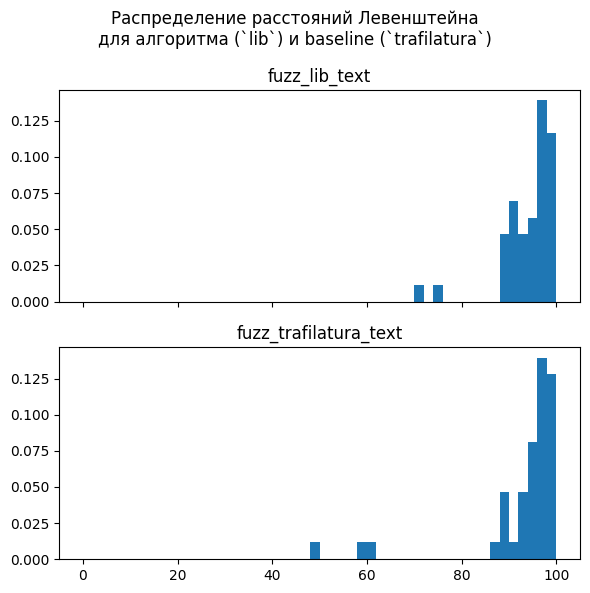

In [15]:
import rapidfuzz.fuzz as fuzz

fuzz_ratios = data_full.apply(
    lambda x: {
        'fuzz_lib_text': fuzz.ratio(x[("cleaned_text", "human")], x[("cleaned_text", "lib")]),
        'fuzz_trafilatura_text': fuzz.ratio(x[("cleaned_text", "human")], x[("cleaned_text", "trafilatura")]),
    },
    result_type="expand",
    axis=1,
)
fuzz_ratios.hist(sharex=True, sharey=True, bins=range(0, 102, 2), layout=(2, 1), figsize=(6, 6), grid=False, density=True)
plt.suptitle("Распределение расстояний Левенштейна\nдля алгоритма (`lib`) и baseline (`trafilatura`)")
plt.tight_layout()
fuzz_ratios.describe()

В целом и изучаемый алгоритм и baseline показали себя неплохо по этой метрике, но baseline очень плохо отработал в нескольких случаях.

#### ROUGE

In [16]:
import evaluate
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kobalt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kobalt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kobalt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [17]:
rouge_ru = evaluate.load('Remeris/rouge_ru')

rouge_metrics = pd.concat(
    [
        data_full.apply(
            # TODO: векторизовать расчёт метрики?
            lambda x: rouge_ru.compute(predictions=[x[('cleaned_text', 'trafilatura')]], references=[x[('cleaned_text', 'human')]])['rougeL'],
            result_type='expand',
            axis=1
        ).add_prefix("rouge_").add_suffix("_trafilatura_text"),
        data_full.apply(
            lambda x: rouge_ru.compute(predictions=[x[('cleaned_text', 'lib')]], references=[x[('cleaned_text', 'human')]])['rougeL'],
            result_type='expand',
            axis=1
        ).add_prefix("rouge_").add_suffix("_lib_text"),
    ],
    axis=1
 )

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kobalt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kobalt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


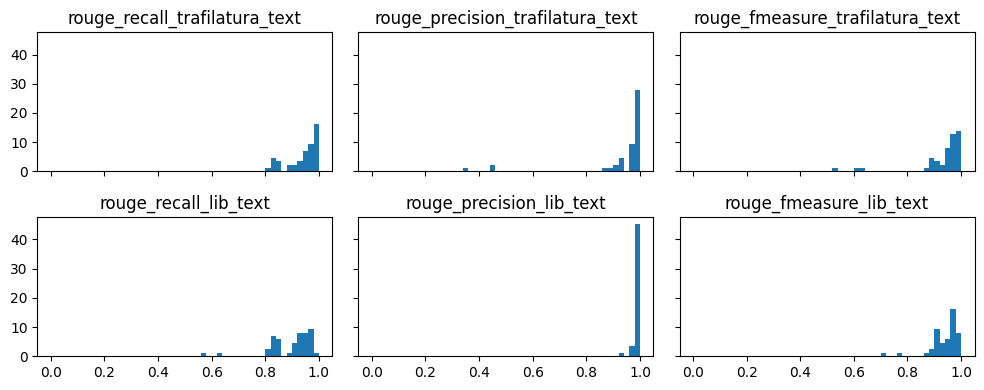

In [18]:
import numpy as np

rouge_metrics.hist(bins=np.arange(0, 1.02, 0.02), layout=(2, 3), figsize=(10, 4), grid=False, density=True, sharex=True, sharey=True)
plt.tight_layout()
rouge_metrics.describe().style.format("{:n}")

В целом изучаемый алгоритм содержит меньше мусора (выше точность), но и выделяет не все нужные данные с сайтов (меньше recall). Среднее гармоническое метрик выше у изучаемой модели.

### Семантический анализ

#### BERTScore

In [19]:
from bert_score import score

def bert_score_to_dict(cands, refs):
    p, r, f = score(cands, refs, lang="ru")

    return {"precision": p.detach().item(), "recall": r.detach().item(), "f1": f.detach().item()}

In [20]:
bertscores = pd.concat(
    [
        data_full.apply(
            lambda x: bert_score_to_dict([x[('cleaned_text', 'lib')]], [x[('cleaned_text', 'human')]]),
            result_type='expand',
            axis=1,
        ).add_prefix("bertscore_").add_suffix("_lib"),
        data_full.apply(
            lambda x: bert_score_to_dict([x[('cleaned_text', 'trafilatura')]], [x[('cleaned_text', 'human')]]),
            result_type='expand',
            axis=1,
        ).add_prefix("bertscore_").add_suffix("_trafilatura"),
    ],
    axis=1
 )


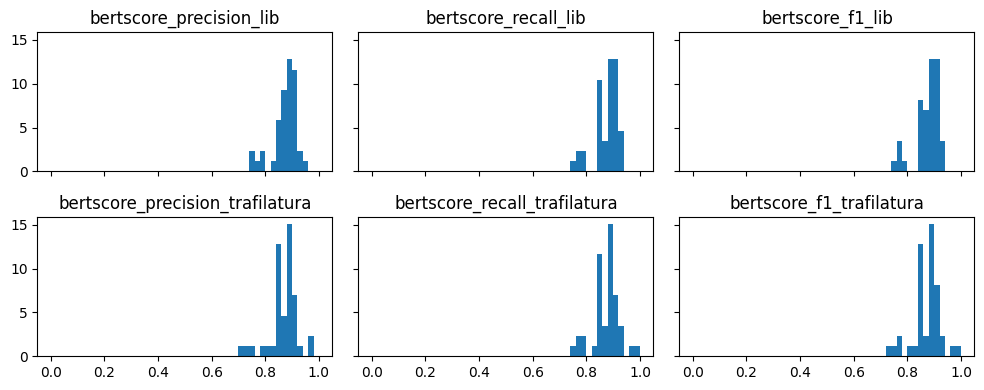

In [21]:
bertscores.hist(bins=np.arange(0, 1.02, 0.02), layout=(2, 3), figsize=(10, 4), grid=False, density=True, sharex=True, sharey=True)
plt.tight_layout()
bertscores.describe().style.format("{:n}")

In [22]:
pd.concat({'bert_scores': bertscores[(bertscores < 0.8).any(axis=1)]}, axis=1).join(data_full)

bert_scores  \
                                                   bertscore_precision_lib   
raw_url                                                                      
https://expert.ru/ekonomika/vygodna-li-rossii-o...                0.798631   
https://www.vesti.ru/article/4393501                              0.761569   
https://www.vesti.ru/article/4371632                              0.757830   
https://expert.ru/ekonomika/maksim-reshetnikov-...                0.789515   
https://ria.ru/20250310/kallas-2003924425.html                    0.933342   
https://ria.ru/20250311/vojska-2004271868.html                    0.913123   
https://expert.ru/mnenie/maksim-reshetnikov-niz...                0.741327   
https://ria.ru/20250310/poshliny-2003708178.html                  0.895355   

                                                                         \
                                                   bertscore_recall_lib   
raw_url                                                                   
https://expert.ru/ekonomika/vygodna-li-rossii-o...             0.795617   
https://www.vesti.ru/article/4393501                           0.785273   
https://www.vesti.ru/article/4371632                           0.770677   
https://expert.ru/ekonomika/maksim-reshetnikov-...             0.769822   
https://ria.ru/20250310/kallas-2003924425.html                 0.938569   
https://ria.ru/20250311/vojska-2004271868.html                 0.921532   
https://expert.ru/mnenie/maksim-reshetnikov-niz...             0.741078   
https://ria.ru/20250310/poshliny-2003708178.html               0.899873   

                                                                     \
                                                   bertscore_f1_lib   
raw_url                                                               
https://expert.ru/ekonomika/vygodna-li-rossii-o...         0.797121   
https://www.vesti.ru/article/4393501                       0.773239   
https://www.vesti.ru/article/4371632                       0.764200   
https://expert.ru/ekonomika/maksim-reshetnikov-...         0.779544   
https://ria.ru/20250310/kallas-2003924425.html             0.935948   
https://ria.ru/20250311/vojska-2004271868.html             0.917309   
https://expert.ru/mnenie/maksim-reshetnikov-niz...         0.741203   
https://ria.ru/20250310/poshliny-2003708178.html           0.897608   

                                                                                    \
                                                   bertscore_precision_trafilatura   
raw_url                                                                              
https://expert.ru/ekonomika/vygodna-li-rossii-o...                        0.805438   
https://www.vesti.ru/article/4393501                                      0.868022   
https://www.vesti.ru/article/4371632                                      0.859634   
https://expert.ru/ekonomika/maksim-reshetnikov-...                        0.789515   
https://ria.ru/20250310/kallas-2003924425.html                            0.722985   
https://ria.ru/20250311/vojska-2004271868.html                            0.746344   
https://expert.ru/mnenie/maksim-reshetnikov-niz...                        0.821420   
https://ria.ru/20250310/poshliny-2003708178.html                          0.700566   

                                                                                 \
                                                   bertscore_recall_trafilatura   
raw_url                                                                           
https://expert.ru/ekonomika/vygodna-li-rossii-o...                     0.799887   
https://www.vesti.ru/article/4393501                                   0.860775   
https://www.vesti.ru/article/4371632                                   0.857563   
https://expert.ru/ekonomika/maksim-reshetnikov-...                     0.769822   
https://ria.ru/20250310/kallas-2003924425.html                      

Алгоритм и baseline практически идентичны по сохранению смыслового содержания текстов. Обе модели лишились баллов из-за не включения заголовка, подзаголовка и подводки. 
Новости о благотворительности серьёзно дополнялись со временем, поэтому показывают низкую точность и полноту.
В самом худшем случае алгоритм не учитывал целые абзацы в теле материала.

### Сохранение результатов

In [23]:
fuzz_ratios.columns = fuzz_ratios.columns.str.removesuffix("_text")
rouge_metrics.columns = rouge_metrics.columns.str.removeprefix("rouge_").str.removesuffix("_text")
bertscores.columns = bertscores.columns.str.removeprefix("bertscore_")

data_export = pd.concat(
    [
        data_full,
        pd.concat({'fuzz_ratios': fuzz_ratios}, axis=1),
        pd.concat({'rouge_metrics': rouge_metrics}, axis=1),
        pd.concat({'bert_scores': bertscores}, axis=1)
    ],
    axis=1
)

In [24]:
data_export.to_parquet("data/final.parquet")

## Выводы

Мы очистили имеющиеся данные, отбросили 7 записей из 50 как нерелевантные анализу (как дубликаты или как не медийный материал), вручную извлекли эталонные тексты с сайтов, леммезировали тексты, рассчитали статистические и семантические метрики качества по сравнению с базовой моделью - алгоритмом библиотеки `trafilatura` со стандартными настройками.

Изучаемый алгоритм показал себя незначительно лучше, чем `trafilatura`, хотя и проигрывал ему по полноте. В зависимости от целей извлечения текстов, можно предложить следующие изменения в алгоритме:
- добавить в алгоритм извлечение информации о форматировании, для извлечения заголовков, цитат, списков, гиперсылок и т.п.
- при наличии данных о форматировании будет проще настроить извлечение NER - ключевых лиц (политиков, звёзд, корреспондентов), места, события и т.п.; эти сущности могут дать контекст для обучения на извлечённых данных моделей ML;
- добавить анализ содержимого изображений в новостях;
- возможно для последующего анализа извлекать тип текста. Например, мы столкнулись с новостями, статьями, спецпроектами, фотогалереями и т.п. Также это позволит автоматически игнорировать служебные ссылки, как, например, политику обработки перс. данных.
- адаптировать алгоритм под особенности крупных новостных сайтов, чтобы улучшить качество извлечения большей части материалов. Можно добавить периодическую проверку качества извлечения на уже размеченных старых новостях, чтобы отследить изменения в верстке новостного сайта и внести правки в алгоритм.
- в алгоритм получения ссылок для последующего извлечения текста добавить шаг по определению финальной ссылки - учитывать перенаправления, а также обрезку якорей (участок ссылки после знака `#` в конце ссылки). Это позволит избежать дубликатов в базе и немного снизит вычислительную нагрузку;

## Литература

- [LLM Evaluation Metrics: The Ultimate LLM Evaluation Guide ](https://www.confident-ai.com/blog/llm-evaluation-metrics-everything-you-need-for-llm-evaluation)
- [Mastering ROUGE Matrix ](https://dev.to/aws-builders/mastering-rouge-matrix-your-guide-to-large-language-model-evaluation-for-summarization-with-examples-jjg)
- [Основы Natural Language Processing для текста ](https://habr.com/ru/companies/Voximplant/articles/446738/)
- [Text Embeddings: Comprehensive Guide ](https://medium.com/data-science/text-embeddings-comprehensive-guide-afd97fce8fb5)
- [Эволюция метрик качества машинного перевода. Часть 2 ](https://habr.com/ru/articles/748496/)